In [2]:
import os
import pickle
import sys
from datetime import datetime as dt

import hydra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torchmetrics
from tqdm.auto import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

sys.path.append("..")

from src.lib.config import register_configs  # noqa
from src.utils.EvalWrapper import EvalWrapper  # noqa
from src.utils import utils  # noqa
from src.utils.eval_single_helper_funcs import get_confidence_and_acc_single, get_distribution_file  # noqa
from src.models.LightningBaseModel import LightningModel  # noqa
from src.utils.eval_single_helper_funcs import get_best_checkpoints  # noqa

register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)

sns.set()

<class 'ValueError'>


In [2]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/publication/supervised_singlelabel", 
                                                     "random_seed=7", 
                                                     "strategy=SingleDevice", 
                                                     'strategy.device="cuda:0"', 
                                                     "trainer.enable_progress_bar=false",
                                                     "datamodule.batch_size=64"])

train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup(stage="fit")

Global seed set to 7
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
77it [00:00, 4898.70it/s]                                                                                                                                                                                                                                                                                                                                                                                    | 0/19 [00:00<?, ?it/s]
4536it [00:00, 8400.81it/s]
88it [00:00, 6581.41it/s]██████████████████████████████████▋                                                                                                                                                                                                                   

In [3]:
class_names = dict()
for key, value in datamodule.integer_class_label_dict.items():
    class_names[value] = key

In [4]:
# set global values:


experiments_paths = {
        "finetune_frozen": [
            "/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05",
            "/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-18/11-59-15"
        ],
        "supervised_singlelabel": [
            "/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24",
            "/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-18/12-00-06"
        ],
        "finetune_singlelabel": [
            "/gpfs/work/machnitz/plankton_logs/finetune/singlelabel/multirun/2022-05-05/07-02-47"
        ],
        "linear_singlelabel": [
            "/gpfs/work/machnitz/plankton_logs/linear_eval/singlelabel/multirun/2022-05-06/13-58-58",
            "/gpfs/work/machnitz/plankton_logs/linear_eval/singlelabel/multirun/2022-05-18/11-58-29"
        ],
        "finetune_sgd_singlelabel": [
            "/gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-05-17/07-38-08",
            "/gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-05-18/11-59-28"
        ],
    }


base_paths = ["/gpfs/work/machnitz/plankton_logs/eval/singlelabel/multirun/2022-05-19/08-24-05/0/logs/checkpoints/test_results",
             ]

experiments = []
for key, paths in experiments_paths.items():
    for path in paths:
        experiments += get_best_checkpoints(path)
        
# experiments = [os.path.join(os.path.split(exp)[0], "last.ckpt") for exp in experiments]
num_total_train_images = 143343

  0%|          | 0/25 [00:00<?, ?it/s]

Did not find checkpoint for /gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/24


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Did not find checkpoint for /gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/12


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Did not find checkpoint for /gpfs/work/machnitz/plankton_logs/linear_eval/singlelabel/multirun/2022-05-06/13-58-58/24


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Did not find checkpoint for /gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-05-17/07-38-08/12


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
experiments

['/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/7/logs/checkpoints/epoch=07.ckpt',
 '/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/21/logs/checkpoints/epoch=00-v6.ckpt',
 '/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/6/logs/checkpoints/epoch=12.ckpt',
 '/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/3/logs/checkpoints/epoch=01.ckpt',
 '/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/11/logs/checkpoints/epoch=00.ckpt',
 '/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/19/logs/checkpoints/epoch=12.ckpt',
 '/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/14/logs/checkpoints/epoch=04.ckpt',
 '/gpfs/work/machnitz/plankton_logs/finetune_frozen/singlelabel/multirun/2022-05-06/14-46-05/17/l

In [6]:
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.set()

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

In [7]:
def custom_accuracy(y_pred, y_true):
    
    _, preds =  torch.max(y_pred, dim=1)
    
    score = y_true == preds
    return score.float().mean()

def instantiate_model(ckpt_path):
    model = LightningModel.load_from_checkpoint(checkpoint_path=ckpt_path)
    model.set_external_data(
        class_labels=[1],
        all_labels=None,
        example_input_array=None,
    )
    return model

# Single Label

In [8]:
def get_training_walltime(_file):
    _path = os.path.split(_file)[0] + "../../.."
    log_file = os.path.abspath(os.path.join(_path, "main.log"))
    with open(log_file, "r") as f:
        lines = f.readlines()
    
    start_str = lines[0].split(",")[0][1:].strip()
    start_time = dt.strptime(start_str, "%Y-%m-%d %H:%M:%S")
    
    end_str = lines[-1].split(",")[0][1:].strip()
    end_time = dt.strptime(end_str, "%Y-%m-%d %H:%M:%S")
    
    wall_time = float((end_time - start_time).total_seconds() / 60)
    
    return wall_time


In [9]:
def get_key_from_filename(_file):
    normed_file = os.path.normpath(_file)
    _key = normed_file.split("plankton_logs/")[-1].split("/singlelabel/")[0] + "_singlelabel"
    _experiment_number = int(normed_file.split("/logs/")[0].split("/")[-1])
    
    return _key, _experiment_number


best_checkpoints = []
return_metrics = dict()
acc_func_macro = torchmetrics.Accuracy(average="macro", num_classes=15)
acc_func_weighted = torchmetrics.Accuracy(average="weighted", num_classes=15)
acc_func_all = torchmetrics.Accuracy(average="none", num_classes=15)
acc_func_micro = torchmetrics.Accuracy(average="micro")
acc_func_custom = custom_accuracy
ConfusionMatrix = torchmetrics.ConfusionMatrix(num_classes=15)

key = None
key_old = None
for file in tqdm(experiments):
    key, experiment_number = get_key_from_filename(file)
    data_fraction = utils.get_split_from_checkpoint_file(file)
    fraction_str =  f"{np.round(data_fraction, 12):.8f}".replace("0.", "0_").replace("1.", "1_")

    if not key in return_metrics.keys():
        return_metrics[key] = dict()
    return_metrics[key][experiment_number] = dict()


    # print(f"loading {key}_{experiment_number} from file")
    
    found_eval=False
    for base_path in base_paths:
        if os.path.exists(os.path.join(base_path, f"logits_{key}_{fraction_str}.pt")):
            found_eval = True
            # print(f"found eval <logits_{key}_{fraction_str}.pt>")
            break
    
    if not found_eval:
        # raise FileNotFoundError(f"Did not find evaluated results for <logits_{key}_{fraction_str}.pt>")
        continue
    
    logits = torch.load(os.path.join(base_path, f"logits_{key}_{fraction_str}.pt"), map_location=torch.device('cpu'))
    predictions = logits.max(dim=1)[1].cpu().numpy()
    _, predicted_distribution = np.unique(predictions, return_counts=True)
    labels = torch.load(os.path.join(base_path, f"labels_{key}_{fraction_str}.pt"), map_location=torch.device('cpu'))
    _, real_distribution = np.unique(labels.cpu().numpy(), return_counts=True)
    with open(os.path.join(base_path, f"dict_{key}_{fraction_str}.pkl"), 'rb') as f:
        loaded_dict = pickle.load(f)
        return_metrics[key][experiment_number] = loaded_dict[key][experiment_number]
        # print(f"{key}_{experiment_number}: {loaded_dict}")
        
    checkpoint = torch.load(file, map_location=torch.device('cpu'))
    return_metrics[key][experiment_number]["Training Steps"] = checkpoint["global_step"]
    
    return_metrics[key][experiment_number]["Data Fraction"] = utils.get_split_from_checkpoint_file(file)
    
    return_metrics[key][experiment_number]["Train Images"] = int(return_metrics[key][experiment_number]["Data Fraction"] * num_total_train_images)
    return_metrics[key][experiment_number]["Accuracy micro"] = acc_func_micro(logits, labels).item()
    return_metrics[key][experiment_number]["Accuracy macro"] = acc_func_macro(logits, labels).item()
    return_metrics[key][experiment_number]["Accuracy weighted"] = acc_func_weighted(logits, labels).item()
    return_metrics[key][experiment_number]["Accuracy custom"] = acc_func_custom(logits, labels).item()
    return_metrics[key][experiment_number]["Wall time"] = get_training_walltime(file) 
    
    return_metrics[key][experiment_number]["Predicted Distribution"] = predicted_distribution 
    
    class_accs = acc_func_all(logits, labels)
    
    for name, class_acc in zip(class_names.values(), class_accs):
        return_metrics[key][experiment_number][f"Accuracy {name}"] = class_acc.item()


    accuracies, confidences, ece = get_confidence_and_acc_single(logits, labels)
    return_metrics[key][experiment_number]["ECE"] = ece

    prob_scaling = EvalWrapper(temperature_file=None,
                               training_distribution_file=get_distribution_file('/gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-05-04/19-41-16/18/logs/checkpoints/epoch=09.ckpt'),
                               device="cpu")
    

    corrected_probabilities = prob_scaling(logits=logits, correct_probabilities_with_training_prior=True)

    return_metrics[key][experiment_number]["Accuracy micro corrected"] = acc_func_micro(corrected_probabilities, labels).item()
    return_metrics[key][experiment_number]["Accuracy macro corrected"] = acc_func_macro(corrected_probabilities, labels).item()
    return_metrics[key][experiment_number]["Accuracy weighted corrected"] = acc_func_weighted(corrected_probabilities, labels).item()
    return_metrics[key][experiment_number]["Accuracy custom corrected"] = acc_func_custom(corrected_probabilities, labels).item()
    class_accs_corrected = acc_func_all(corrected_probabilities, labels)
    
    for name, class_acc in zip(class_names.values(), class_accs_corrected):
        return_metrics[key][experiment_number][f"Accuracy {name} corrected"] = class_acc.item()

    accuracies_corrected, confidences_corrected, ece_corrected = get_confidence_and_acc_single(
        corrected_probabilities,
        labels,
        logits_are_probs=True)

    return_metrics[key][experiment_number]["ECE Prior Corrected"] = ece_corrected


    # add cm matrices:
    cm_uncorrected = ConfusionMatrix(logits.max(dim=1)[1].cpu().detach(), labels.cpu().detach())
    cm_uncorrected_norm = ConfusionMatrix(logits.max(dim=1)[1].cpu().detach(), labels.cpu().detach(), normalize="true")
    cm_corrected = ConfusionMatrix(corrected_probabilities.max(dim=1)[1].cpu().detach(), labels.cpu().detach())
    cm_corrected_norm = ConfusionMatrix(corrected_probabilities.max(dim=1)[1].cpu().detach(), labels.cpu().detach(), normalize="true")
    return_metrics[key][experiment_number]["CM Uncorrected"] = cm_uncorrected
    return_metrics[key][experiment_number]["CM Uncorrected Normalized"] = cm_uncorrected_norm
    return_metrics[key][experiment_number]["CM Corrected"] = cm_corrected
    return_metrics[key][experiment_number]["CM Corrected Normalized"] = cm_corrected_norm

    key_old = key

    break

  0%|          | 0/101 [00:00<?, ?it/s]

TypeError: update() got an unexpected keyword argument 'normalize'

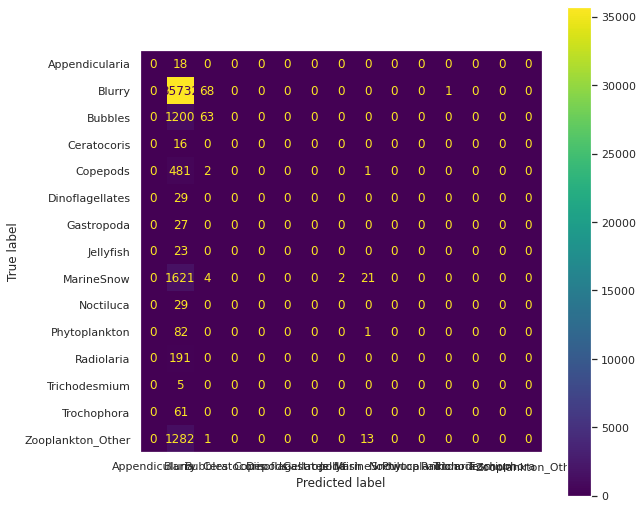

In [26]:
fig, ax = plt.subplots(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix=return_metrics[key][experiment_number]["CM Corrected"].numpy(), display_labels=datamodule.unique_labels)
disp.plot(ax=ax)
ax.grid(False)
plt.show()

In [54]:
file

'/gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-05-18/11-59-28/0/logs/checkpoints/epoch=00-v6.ckpt'

In [55]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in return_metrics.items() for innerKey, values in
          innerDict.items()}
single_label_df = pd.DataFrame.from_dict(reform).T
single_label_df.index.names = ("Model", "Experiment")
single_label_df = single_label_df.sort_values(by=["Model"])
single_label_df = single_label_df[single_label_df["Data Fraction"] >= 1e-3]
single_label_df

loss/Testing Accuracy/Testing  \
Model                       Experiment                                 
finetune_frozen_singlelabel 18             0.420585         0.890955   
                            15              0.49855         0.871626   
                            12             0.659088         0.835408   
                            22              0.40875         0.874237   
                            16             0.501948         0.854444   
...                                             ...              ...   
supervised_singlelabel      1               0.86893         0.787914   
                            0              0.264413         0.928442   
                            9              0.287232         0.922219   
                            2              0.744197         0.838849   
                            10             0.230786         0.938107   

                                       Data Fraction Best Epoch  \
Model                       Experiment                            
finetune_frozen_singlelabel 18                  0.05         07   
                            15                0.0075         02   
                            12                 0.001         02   
                            22                   0.5      03-v5   
                            16                  0.01         00   
...                                              ...        ...   
supervised_singlelabel      1                 0.0025         30   
                            0                    1.0      02-v3   
                            9                   0.25      04-v3   
                            2                  0.005         41   
                            10                   0.5      02-v6   

                                       Training Steps Train Images  \
Model                       Experiment                               
finetune_frozen_singlelabel 18                  11283         7167   
                            15                    663         1075   
                            12                     90          143   
                            22                  55052        71671   
                            16                    294         1433   
...                                               ...          ...   
supervised_singlelabel      1                    2294          358   
                            0                   87734       143343   
                            9                   36368        35835   
                            2                    6174          716   
                            10                  41368        71671   

                                       Accuracy micro Accuracy macro  \
Model                       Experiment                                 
finetune_frozen_singlelabel 18               0.890955       0.373887   
                            15               0.871626       0.285181   
                            12               0.835408       0.238048   
                            22               0.874237       0.543454   
                            16               0.854444       0.277776   
...                                               ...            ...   
supervised_singlelabel      1                0.787914       0.212055   
                            0                0.928442        0.68576   
                            9                0.922219       0.536698   
                            2                0.838849       0.228886   
                            10               0.938107       0.559849   

                                       Accuracy weighted Accuracy custom  ...  \
Model                       Experiment                                    ...   
finetune_frozen_singlelabel 18                  0.890955        0.890955  ...   
                            15                  0.871626        0.871626  ...   
                            12                  0.835408  

In [73]:
figsize=(9,3)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


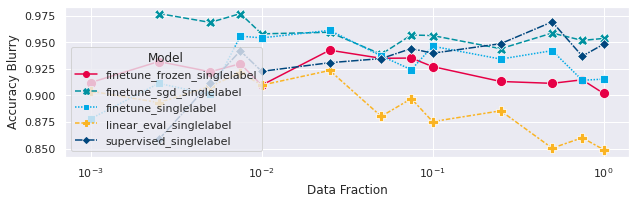

In [74]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy Blurry", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


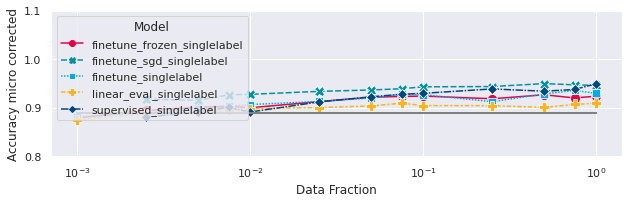

In [76]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy micro corrected", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )
ax.plot(single_label_df["Data Fraction"], [0.89 for _ in single_label_df["Data Fraction"]], color="grey", ls="-.")
# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.set_ylim(0.8, 1.1)
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


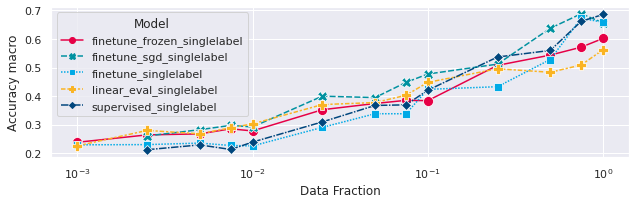

In [77]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy macro", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


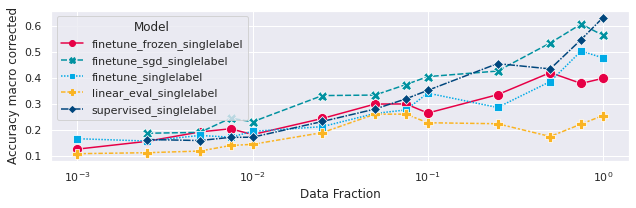

In [78]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy macro corrected", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )
# ax.plot(single_label_df["Data Fraction"], [1/15 for _ in single_label_df["Data Fraction"]], color="grey", ls="--")
# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


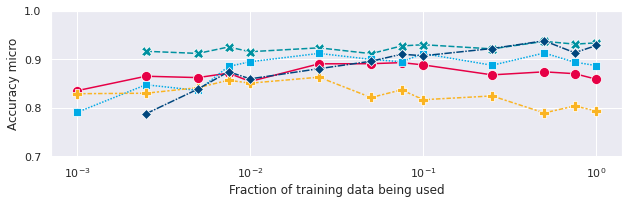

In [85]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy micro", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xlabel("Fraction of training data being used")
ax.set_ylim(0.7, 1)
ax.set_xscale("log")
ax.legend()
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel_micro_pure.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


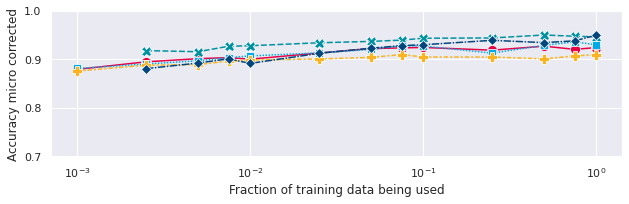

In [86]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy micro corrected", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.set_xlabel("Fraction of training data being used")
ax.set_ylim(0.7, 1)
ax.legend()
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel_micro_corrected.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


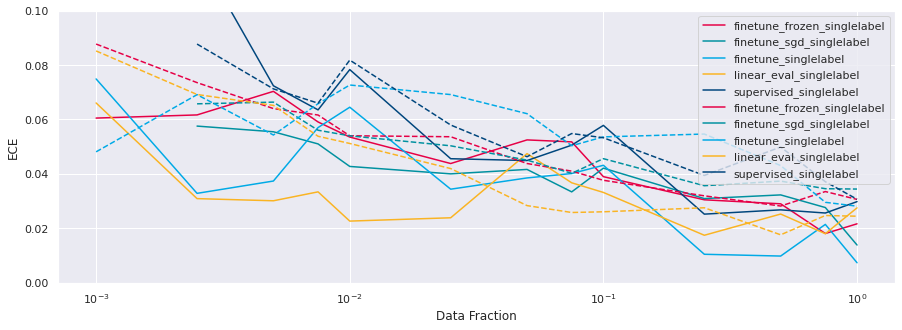

In [62]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="ECE", hue="Model", linestyle="solid", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

sns.lineplot(x="Data Fraction", y="ECE Prior Corrected", hue="Model", linestyle="dashed",
        data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# sns.lineplot(x="Data Fraction", y="ECE Temp Corrected", hue="Model", linestyle=":",
#         data=single_label_df, ax=ax,
#              palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item, 0.2, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.set_ylim(0, 0.1)
ax.legend(loc="best")
plt.savefig("ECE_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


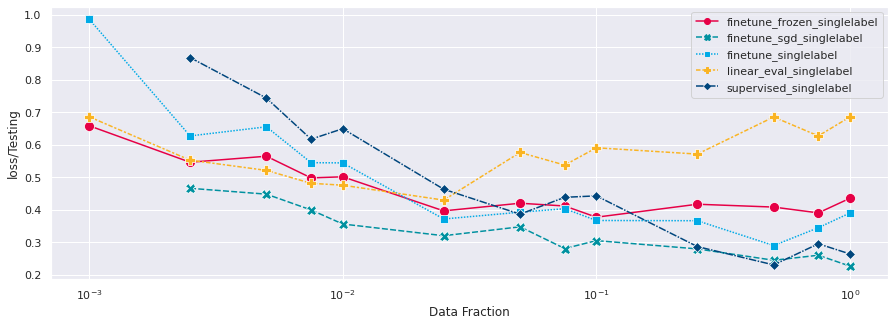

In [63]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="loss/Testing", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item, 0.6, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("NLL_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


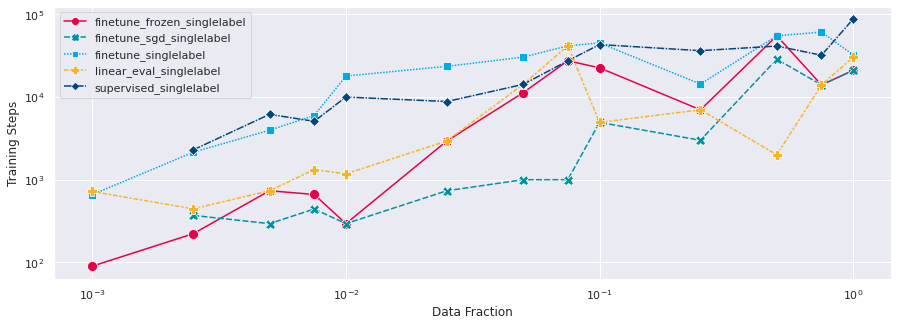

In [64]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Training Steps", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item, 0.6, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")
plt.tight_layout()
plt.savefig("Training_Steps_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


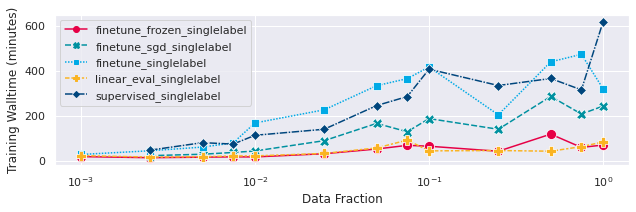

In [88]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Wall time", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

ax.set_ylabel("Training Walltime (minutes)")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.legend(loc="best")
plt.tight_layout()
plt.savefig("Traing_Walltimes_Singlelabel.png", dpi=300)

In [66]:
predicted_dist_dict = dict()
for key in datamodule.unique_labels:
    predicted_dist_dict[key] = dict()

for model, index_2 in single_label_df.index:
    pd_series = single_label_df.loc[model, index_2]
    predicted_dist = pd_series["Predicted Distribution"]
    data_fraction = pd_series["Data Fraction"]
    
    for key, value, real_value in zip(predicted_dist_dict.keys(), predicted_dist, real_distribution):
        if not model in predicted_dist_dict[key].keys():
            predicted_dist_dict[key][model] = dict()
        predicted_dist_dict[key][model][data_fraction] = dict()
        predicted_dist_dict[key][model][data_fraction]["Predicted Count"] = value
        predicted_dist_dict[key][model][data_fraction]["Real Count"] = real_value
        
dfs = dict()
for key, value in predicted_dist_dict.items():
    reform = {(outerKey, innerKey): values for outerKey, innerDict in value.items() for innerKey, values in
              innerDict.items()}
    distribution_df = pd.DataFrame.from_dict(reform).T
    distribution_df.index.names = ("Model", "Data Fraction")
    distribution_df
    dfs[key] = distribution_df.reset_index().sort_values(by="Model")

In [67]:
dfs["Appendicularia"]

,Model,Data Fraction,Predicted Count,Real Count
0,finetune_frozen_singlelabel,0.050,89,18
12,finetune_frozen_singlelabel,0.005,142,18
11,finetune_frozen_singlelabel,0.025,42,18
10,finetune_frozen_singlelabel,0.250,95,18
8,finetune_frozen_singlelabel,0.750,101,18
...,...,...,...,...
52,supervised_singlelabel,0.050,33763,18
51,supervised_singlelabel,0.075,2,18
61,supervised_singlelabel,0.005,46,18
55,supervised_singlelabel,0.025,2,18


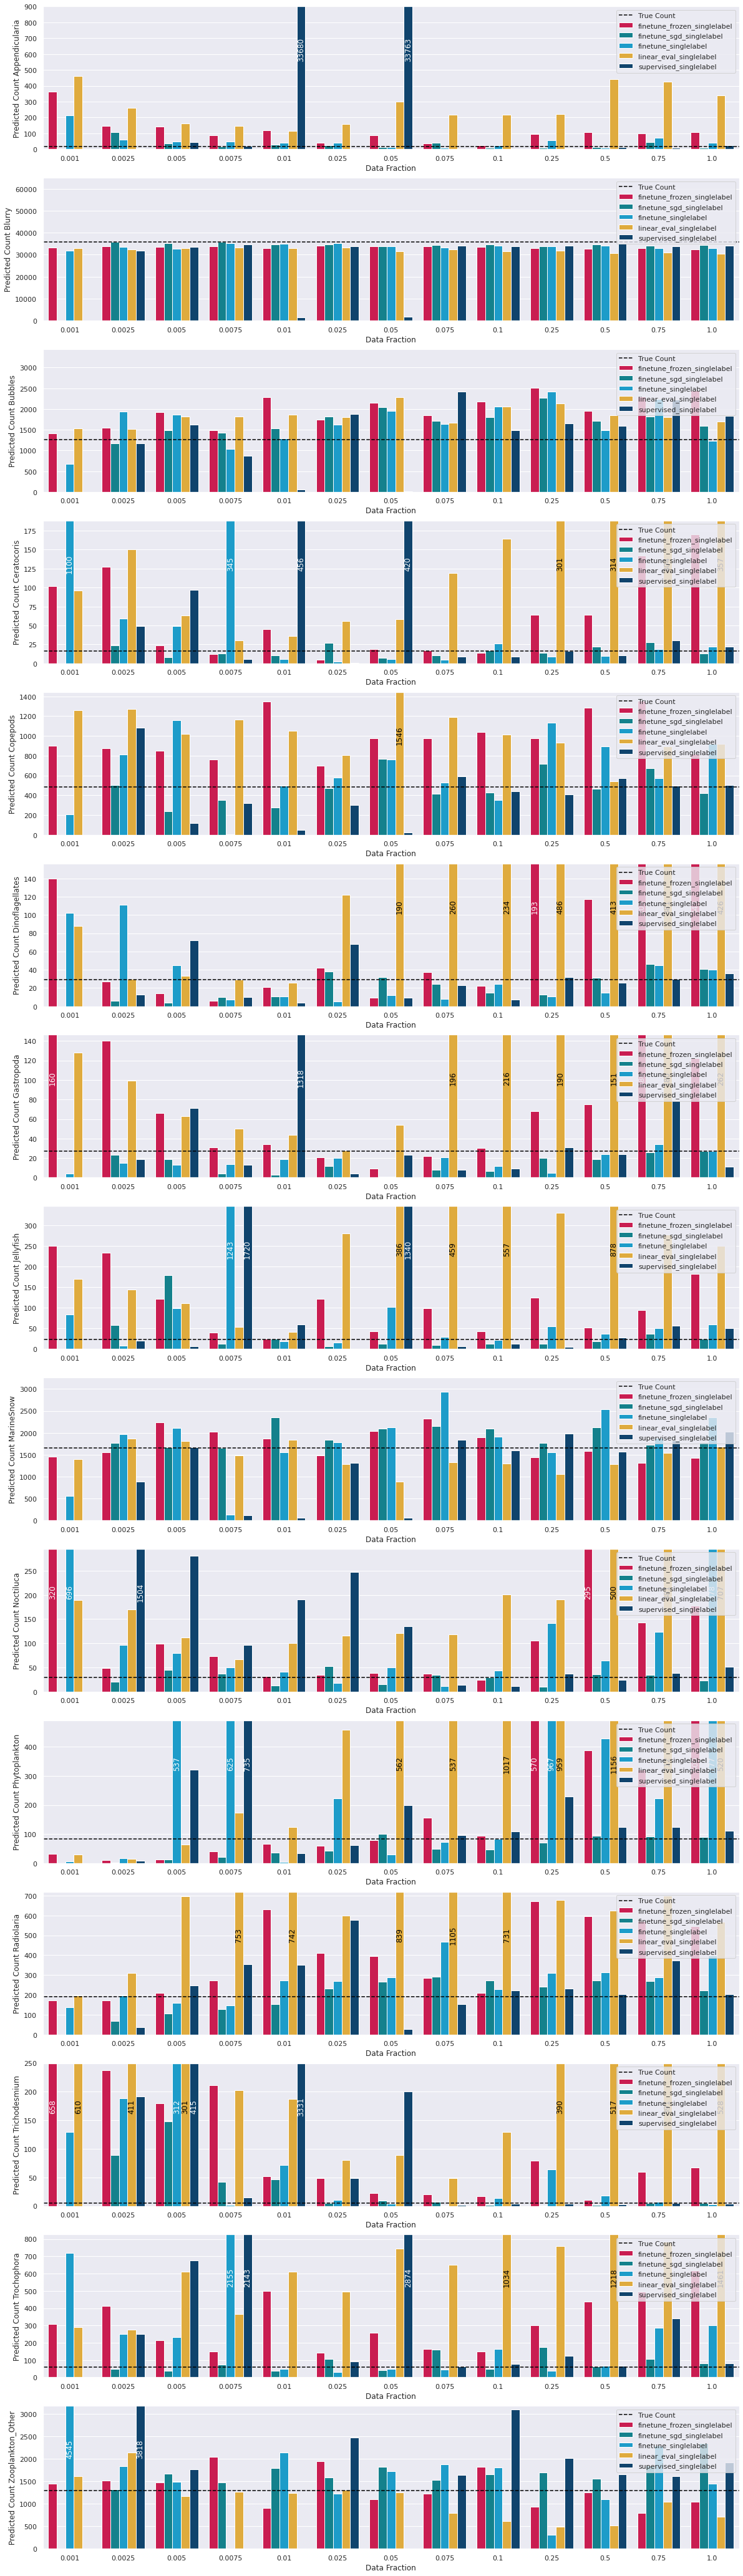

In [68]:
fig, axes = plt.subplots(nrows=len(dfs.keys()), figsize=(20,5 *len(dfs.keys())))

for ax, species in zip(axes.flatten(), dfs.keys()):
    sns.barplot(x="Data Fraction", y="Predicted Count", hue="Model", data=dfs[species], ax=ax)
    
    max_height =  min(dfs[species]["Predicted Count"].mean() * 2, dfs[species]["Real Count"].max() * 50)
    ax.set_ylim(0, max_height)

    
    ax.plot(np.linspace(-5, 20, 100), [dfs[species]["Real Count"].max() for x in np.linspace(-2, 2, 100)], c="black", ls="--", label="True Count")
    ax.set_xlim(-0.5,12.5)
    # ax.set_xlabel("true samples")
    ax.set_ylabel(f"Predicted Count {species}")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.legend(loc="upper right")
    
    
    for p in ax.patches:
        if p.get_height() > max_height:
            color = p.get_facecolor()
            if sum(color) < 2.6:
                text_color="white"
            else:
                text_color="black"
            ax.annotate(int(p.get_height()),
                        (p.get_x() + p.get_width() / 2., max_height * 0.66),
                        ha='center', va='center',
                        rotation=90,
                        xytext=(0, 9),
                        textcoords='offset points',
                        color=text_color)
plt.show()
plt.savefig("AllPredictedDistributions.png", dpi=300)

In [26]:
# predicted_dist_dict = dict()

# for model, index_2 in single_label_df.index:
#     if not model in predicted_dist_dict.keys():
#         predicted_dist_dict[model] = dict()
#     pd_series = single_label_df.loc[model, index_2]
#     predicted_dist = pd_series["Predicted Distribution"]
#     data_fraction = pd_series["Data Fraction"]
    
#     for key in datamodule.unique_labels:
#         if not key in predicted_dist_dict[model].keys():
#             predicted_dist_dict[model][key] = dict()
        
#     for key, value, real_value in zip(predicted_dist_dict[model].keys(), predicted_dist, real_distribution):
#         predicted_dist_dict[model][key][data_fraction] = dict()
#         predicted_dist_dict[model][key][data_fraction]["Predicted Count"] = value
#         predicted_dist_dict[model][key][data_fraction]["Real Count"] = real_value
        
# dfs = dict()
# for key, value in predicted_dist_dict.items():
#     reform = {(outerKey, innerKey): values for outerKey, innerDict in value.items() for innerKey, values in
#               innerDict.items()}
#     distribution_df = pd.DataFrame.from_dict(reform).T
#     distribution_df.index.names = ("Species", "Data Fraction")
#     distribution_df
#     dfs[key] = distribution_df.reset_index().sort_values(by="Species")

In [27]:
# predicted_dist_dict[model].keys()
# dfs["finetune_frozen_singlelabel"]

In [28]:
# fig, axes = plt.subplots(nrows=len(dfs.keys()), figsize=(20,5 *len(dfs.keys())))

# for ax, species in zip(axes.flatten(), dfs.keys()):
#     sns.barplot(x="Data Fraction", y="Predicted Count", hue="Species", data=dfs[species], ax=ax)
    
#     max_height =  min(dfs[species]["Predicted Count"].mean() * 2, dfs[species]["Real Count"].max() * 50)
#     ax.set_ylim(0, max_height)

    
#     ax.plot(np.linspace(-5, 20, 100), [dfs[species]["Real Count"].max() for x in np.linspace(-2, 2, 100)], c="black", ls="--", label="True Count")
#     ax.set_xlim(-0.5,12.5)
#     # ax.set_xlabel("true samples")
#     ax.set_ylabel(f"Predicted Count {species}")
#     # ax.set_xscale("log")
#     # ax.set_yscale("log")
#     ax.legend(loc="upper right")
    
    
#     for p in ax.patches:
#         if p.get_height() > max_height:
#             color = p.get_facecolor()
#             if sum(color) < 2.6:
#                 text_color="white"
#             else:
#                 text_color="black"
#             ax.annotate(int(p.get_height()),
#                         (p.get_x() + p.get_width() / 2., max_height * 0.66),
#                         ha='center', va='center',
#                         rotation=90,
#                         xytext=(0, 9),
#                         textcoords='offset points',
#                         color=text_color)
# plt.show()